# Morris-Lecar model

Reproduces Fig. 9 of:
Catherine Morris and Harold Lecar. “Voltage Oscillations in the Barnacle Giant Muscle Fiber.” Biophysical Journal 35, no. 1 (1981): 193–213.

## Functions 

In [1]:
from brian2 import *
set_device('cpp_standalone')

In [2]:
def generate_simple_synapses(pre, post):
    synapse = Synapses(pre, post, model='''s: 1''', on_pre='v += s')
    return synapse

def generate_simple_muscle_synapses(pre, post):
    synapse = Synapses(pre, post, model='''s: amp''', on_pre='I += s')
    return synapse

def generate_STDP_DA_synapses(pre, post):
    """
    Generates the STDP modulated with DA synapses
    pre -- the presynaptic neurons 
    post -- the postsynaptic neurons 
    mode is external variable: mode = 0 switches off DA modulation, mode = 1 switches on DA modulation.
    s -- synaptic strength      = 1e-10
    c -- eligibility trace      = 1e-10
    d -- extracellular dopamine = 0
    """
    synapse_stdp = Synapses(pre, post,
                          model='''mode: 1
                          dc/dt = -c / tauc : 1 (clock-driven)
                          dd/dt = -d / taud : 1 (clock-driven)
                          ds/dt = mode * c * d / taus : 1 (clock-driven)
                          dApre/dt = -Apre / taupre : 1 (event-driven)
                          dApost/dt = -Apost / taupost : 1 (event-driven)''',
                          on_pre='''v += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                          on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                          method='euler'
                          )
    return synapse_stdp

def generate_ML_muscle(num_fibers):
    # V,N-reduced system (Eq. 9 in article), note that the variables M and N (and lambda_N, etc.)
    # have been renamed to m and n to better match the Hodgkin-Huxley convention, and because N has
    # a reserved meaning in Brian (number of neurons)
    eqs = '''
    dV/dt = (-g_L*(V - V_L) - g_Ca*m_inf*(V - V_Ca) - g_K*n*(V - V_K) + I)/C : volt
    dn/dt = lambda_n*(n_inf - n) : 1
    m_inf = 0.5*(1 + tanh((V - V_1)/V_2)) : 1
    n_inf = 0.5*(1 + tanh((V - V_3)/V_4)) : 1
    lambda_n = lambda_n__max*cosh((V - V_3)/(2*V_4)) : Hz
    I : amp
    '''
    muscle = NeuronGroup(num_fibers, eqs, method='exponential_euler')
    muscle.V = V_L
    muscle.n = 'n_inf'
    return muscle

print('Functions defined ...')

Functions defined ...


## Simulation

In [3]:
start_scope()
defaultclock.dt = 0.01*ms

g_L = 2*mS
g_Ca = 4*mS
g_K = 8*mS
V_L = -50*mV
V_Ca = 100*mV
V_K = -70*mV
lambda_n__max = 1.0/(15*ms)
V_1 = 10*mV
V_2 = 15*mV  # Note that Figure caption says -15 which seems to be a typo
V_3 = -1*mV
V_4 = 14.5*mV
C = 20*uF
muscles_num = 200
motor_freq = 300*Hz
motor_num = 200
motor2mus_conn_probability = 0.9
mus_weight = 703# e-3*uA # 0.9e-3*volt

motor_input = PoissonGroup(motor_num, rates=motor_freq)
mus = generate_ML_muscle(muscles_num)
## mus.I = (np.arange(17)*25+100)*uA
# condition='j==2*i or j==(2*i+1)'
motor2muscle = generate_simple_muscle_synapses(motor_input, mus)
motor2muscle.connect(p=motor2mus_conn_probability)
motor2muscle.s = '(rand() * mus_weight)*1e-4*uA'

mon = StateMonitor(mus, ['V', 'n'], record=True)

run_time = 220*ms
run(run_time, report='text')
print('Simulation is over ...')

Starting simulation at t=0 s for duration 0.22 s
0.22 s (100%) simulated in < 1s
Simulation is over ...


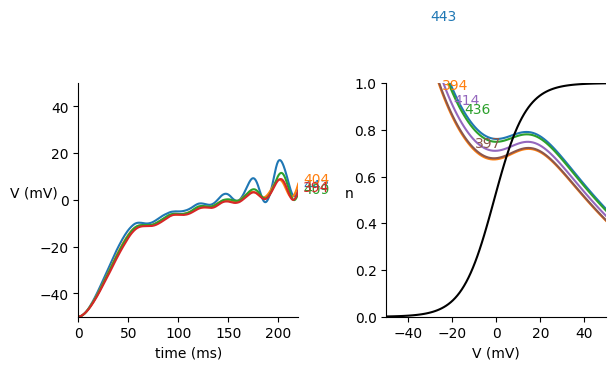

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'right': 0.95, 'bottom': 0.15},
                               figsize=(6.4, 3.2))
fig.subplots_adjust(wspace=0.4)
for line_no, idx in enumerate([0, 4, 12, 15]):
    color = 'C%d' % line_no
    ax1.plot(mon.t/ms, mon.V[idx]/mV, color=color)
    ax1.text(225, mon.V[idx][-1]/mV, '%.0f' % (mus.I[idx]/uA), color=color)
ax1.set(xlim=(0, 220), ylim=(-50, 50), xlabel='time (ms)')
ax1.set_ylabel('V (mV)', rotation=0)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# dV/dt nullclines
V = linspace(-50, 50, 100)*mV
for line_no, (idx, color) in enumerate([(0, 'C0'), (int(muscles_num*0.25), 'C1'), 
                                        (int(muscles_num*0.5), 'C4'), 
                                        (int(muscles_num*0.75), 'C2'), (int(muscles_num-1), 'C5')]):
    n_null = (g_L*(V - V_L) + g_Ca*0.5*(1 + tanh((V - V_1)/V_2))*(V - V_Ca) - mus.I[idx])/(-g_K*(V - V_K))
    ax2.plot(V/mV, n_null, color=color)
    ax2.text(V[20+5*line_no]/mV, n_null[20+5*line_no]+0.01, '%.0f' % (mus.I[idx]/uA), color=color)
# dn/dt nullcline
n_null = 0.5*(1 + tanh((V - V_3)/V_4))
ax2.plot(V/mV, n_null, color='k')
ax2.set(xlim=(-50, 50), ylim=(0, 1), xlabel='V (mV)')
ax2.set_ylabel('n', rotation=0)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()